In [1]:
import numpy as np
import sympy as smp
from centrex_tlf_hamiltonian import states, hamiltonian
import centrex_tlf_couplings as couplings
import centrex_TlF_lindblad as lindblad
import matplotlib.pyplot as plt
import scipy.constants as cst
from labellines import labelLines
import pickle
import datetime
import pandas as pd
import statsmodels.api as sm
plt.rcParams.update({'font.size': 14})

In [2]:
# this cell is tagged parameters
# transition label : 'couplings.OpticalTransition(couplings.OpticalTransitionType.Q/R/..., J_ground, F1_excited, F_excited)'

#transition = 'couplings.OpticalTransition(couplings.OpticalTransitionType.R, 1, F1=1.5, F=2)'
transition = couplings.transition.OpticalTransition(couplings.transition.OpticalTransitionType.R, 1, F1=3/2, F=1)
#transition = 'couplings.transition.OpticalTransition(couplings.transition.OpticalTransitionType.Q, 1, F1=1/2, F=1)'

# polarizations = "[couplings.polarization_Z, couplings.polarization_X]"
#only consider σp polarization light
#polarizations = "[couplings.polarization_Z]"
polarizations = [couplings.polarization_σp, couplings.polarization_σm]
# polarizations = "[couplings.polarization_σp]"

powers = np.linspace(1-2e-3,1+2e-3,4)
forward_velocities = np.arange(90, 300+4, 4)
transverse_velocities = np.arange(-4.5, 4.5+0.2, 0.2)

ωp = 0.1*hamiltonian.Γ
ωphase = hamiltonian.Γ
β = 3.8
ωl = 2*np.pi*100e3

dx = 2.54e-2 # dx of laser beam
dy = 2*2.54e-2 # dy of laser beam

initial_state = states.QuantumSelector(
    J=1, F1=3/2, F=1, mF=0, electronic=states.ElectronicState.X
)

nprocs = 5 # number of processes to use

μvy = 0
σvy = 1.5

now = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')

powers = np.asarray(powers)
forward_velocities = np.asarray(forward_velocities)
transverse_velocities = np.asarray(transverse_velocities)

## Functions to convert Power to Rabi and vice-versa

In [3]:
def power_from_rabi_rectangle(Ω: complex, main_coupling: complex, dx: float, dy: float, D: float = 2.6675506e-30) -> float:
    E = Ω*cst.hbar / (main_coupling * D)
    intensity = 1/2 * cst.c * cst.epsilon_0 * E ** 2
    P = intensity * (dx * dy)
    return P.real

def rabi_from_power_rectangle(power: float, main_coupling: complex, dx: float, dy: float, D: float = 2.6675506e-30) -> complex:
    intensity = power / (dx * dy)
    E = np.sqrt(intensity*2 / (cst.c * cst.epsilon_0))
    Ω = E * main_coupling * D / cst.hbar
    return Ω

## Functions to convert transverse velocity to detuning

In [4]:
def doppler_shift(velocity, frequency):
    """calculate the doppler shifted frequency
    Args:
        velocity (float): velocity [m/s]
        frequency (float): frequency [Hz]
    Returns:
        float: doppler shifted frequency in Hz
    """
    return frequency * (1 + velocity / cst.c)


def velocity_to_detuning(velocity, frequency=1.103e15, Γ=2*np.pi*1.56e6):
    """convert velocity to detuning in units of Γ
    Args:
        velocity (float): velocity [m/s]
        frequency (float): frequency [Hz]
        Γ (float): Γ [2π⋅Hz]
    Returns:
        float: detuning in units of Γ
    """
    return (doppler_shift(velocity, frequency) - frequency) * 2 * np.pi / Γ

## Function to convert diagonal indices to flattened

In [5]:
def get_diagonal_indices_flattened(size, states = None, mode = 'python'):
    if states is None:
        indices = [i+size*i for i in range(size)]
    else:
        indices = [i+size*i for i in states]
    if mode == 'julia':
        return [i+1 for i in indices]
    elif mode == 'python':
        return indices

## System Parameters

In [6]:
syspars = lindblad.SystemParameters(nprocs = nprocs, Γ=hamiltonian.Γ)


## Vibrational Decay Channels

In [7]:
decay_channels = [
    lindblad.DecayChannel(
        ground = 1*states.CoupledBasisState(None, None, None, None, None, None, v = "other",P=+1),
        excited = transition.qn_select_excited,
        branching = 1e-2,
        description = "vibrational decay"
    )
]

## Odepars

In [8]:
v_to_Γ = velocity_to_detuning(1)*syspars.Γ

odepars = lindblad.odeParameters(
    Ω0 = "Ωl0 * phase_modulation(t, β, ωphase)",
    Ωl0     = 1*syspars.Γ,    # Rabi frequency of the laser [rad/s]
    δ0      = f"vy*{v_to_Γ}",              # detuning of the laser [rad/s]

    #laser polarization switching
    ωp = ωp,           # polarization switching frequency [rad/s]
    Pσp0 = "square_wave(t, ωp, 0.)",
    Pσm0 = f"square_wave(t, ωp, {np.pi})",
    β = β,
    ωphase = ωphase,
    ωl = ωl,
    
    # # laser without polarization switching
    # Pσp0 = 1,
    # β = β,
    # ωphase = ωphase,
    # ωl = ωl,

    # molecules
    y0 = 0,                   # molecule start y position [m]
    vz = 184,                 # longitudinal molecular velocity [m/s]
    vy = 0,                   # molecule vy [m/s]
)

## Generate the System

In [9]:
transition_selectors = couplings.generate_transition_selectors([transition], [polarizations], ground_mains = [1*states.CoupledBasisState(F=1, mF=0, F1 = 1/2, J = 1, I1 = 1/2, I2 = 1/2, Omega = 0, P = -1,electronic_state= states.ElectronicState.X)],
excited_mains = [1*states.CoupledBasisState(F=1, mF=1, F1 = 3/2, J = 2, I1 = 1/2, I2 = 1/2, Omega = 1, P = 1, electronic_state= states.ElectronicState.B)])
Ez_reg = np.linspace(20,60,11)
pow_reg = np.linspace(0.01,1,20)
res = []
for Ez in Ez_reg: 
    obe_system = lindblad.setup_OBE_system_julia_transitions(
        odepars, [transition], transition_selectors, verbose=True, full_output=True,
        decay_channels = decay_channels, E=np.array([0,0,Ez]), n_procs = nprocs, qn_compact = True
    )
    for powerf in pow_reg:
        rabi_difW = rabi_from_power_rectangle(powerf, np.abs(obe_system.couplings[0].main_coupling), dx, dy)
        indices_excited = transition.qn_select_excited.get_indices(obe_system.QN)
        ρ = states.population.generate_population_states(
            initial_state.get_indices(obe_system.QN), 
            len(obe_system.QN)
        )
        df = couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground='J')
        odepars.Ωl0 = rabi_difW
        problem = lindblad.OBEProblem(
            odepars,ρ, (0.0,dx/odepars.vz)
        )
        result_single = lindblad.do_simulation_single(problem)
        #print(f"{transition} => {np.trapz(result_single.y[indices_excited].sum(axis=0), x=result_single.t)*hamiltonian.Γ:.2f} photons")
        res.append(np.trapz(result_single.y[indices_excited].sum(axis=0), x=result_single.t)*hamiltonian.Γ)


res_fin = np.reshape(res,(len(Ez_reg),len(pow_reg)))

INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 1/6 -> Generating the reduced Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 2/6 -> Generating the couplings corresponding to the transitions
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 3/6 -> Generating the symbolic Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 4/6 -> Generating the collapse matrices
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 5/6 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 6/6 -> Generating Julia code representing the system of equations
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 1/3 -> Generating the preamble
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 2/3 -> Initializing Julia on 5 cores
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 3/3 -> Defining the ODE equation and param

Initialized Julia with 5 processes


INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 1/6 -> Generating the reduced Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 2/6 -> Generating the couplings corresponding to the transitions
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 3/6 -> Generating the symbolic Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 4/6 -> Generating the collapse matrices
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 5/6 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 6/6 -> Generating Julia code representing the system of equations
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 1/3 -> Generating the preamble
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 2/3 -> Initializing Julia on 5 cores
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 3/3 -> Defining the ODE equation and param

Initialized Julia with 5 processes


INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 1/6 -> Generating the reduced Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 2/6 -> Generating the couplings corresponding to the transitions
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 3/6 -> Generating the symbolic Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 4/6 -> Generating the collapse matrices
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 5/6 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 6/6 -> Generating Julia code representing the system of equations
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 1/3 -> Generating the preamble
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 2/3 -> Initializing Julia on 5 cores
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 3/3 -> Defining the ODE equation and param

Initialized Julia with 5 processes


INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 1/6 -> Generating the reduced Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 2/6 -> Generating the couplings corresponding to the transitions
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 3/6 -> Generating the symbolic Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 4/6 -> Generating the collapse matrices
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 5/6 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 6/6 -> Generating Julia code representing the system of equations
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 1/3 -> Generating the preamble
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 2/3 -> Initializing Julia on 5 cores
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 3/3 -> Defining the ODE equation and parameters in Julia


Initialized Julia with 5 processes


INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 1/6 -> Generating the reduced Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 2/6 -> Generating the couplings corresponding to the transitions
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 3/6 -> Generating the symbolic Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 4/6 -> Generating the collapse matrices
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 5/6 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 6/6 -> Generating Julia code representing the system of equations
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 1/3 -> Generating the preamble
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 2/3 -> Initializing Julia on 5 cores
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 3/3 -> Defining the ODE equation and param

Initialized Julia with 5 processes


INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 1/6 -> Generating the reduced Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 2/6 -> Generating the couplings corresponding to the transitions
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 3/6 -> Generating the symbolic Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 4/6 -> Generating the collapse matrices
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 5/6 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 6/6 -> Generating Julia code representing the system of equations
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 1/3 -> Generating the preamble
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 2/3 -> Initializing Julia on 5 cores
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 3/3 -> Defining the ODE equation and param

Initialized Julia with 5 processes


INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 1/6 -> Generating the reduced Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 2/6 -> Generating the couplings corresponding to the transitions
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 3/6 -> Generating the symbolic Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 4/6 -> Generating the collapse matrices
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 5/6 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 6/6 -> Generating Julia code representing the system of equations
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 1/3 -> Generating the preamble
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 2/3 -> Initializing Julia on 5 cores
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 3/3 -> Defining the ODE equation and param

Initialized Julia with 5 processes


INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 1/6 -> Generating the reduced Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 2/6 -> Generating the couplings corresponding to the transitions
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 3/6 -> Generating the symbolic Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 4/6 -> Generating the collapse matrices
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 5/6 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 6/6 -> Generating Julia code representing the system of equations
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 1/3 -> Generating the preamble
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 2/3 -> Initializing Julia on 5 cores
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 3/3 -> Defining the ODE equation and parameters in Julia


Initialized Julia with 5 processes


INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 1/6 -> Generating the reduced Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 2/6 -> Generating the couplings corresponding to the transitions
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 3/6 -> Generating the symbolic Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 4/6 -> Generating the collapse matrices
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 5/6 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 6/6 -> Generating Julia code representing the system of equations
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 1/3 -> Generating the preamble
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 2/3 -> Initializing Julia on 5 cores
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 3/3 -> Defining the ODE equation and param

Initialized Julia with 5 processes


INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 1/6 -> Generating the reduced Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 2/6 -> Generating the couplings corresponding to the transitions
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 3/6 -> Generating the symbolic Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 4/6 -> Generating the collapse matrices
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 5/6 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 6/6 -> Generating Julia code representing the system of equations
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 1/3 -> Generating the preamble
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 2/3 -> Initializing Julia on 5 cores
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 3/3 -> Defining the ODE equation and param

Initialized Julia with 5 processes


INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 1/6 -> Generating the reduced Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 2/6 -> Generating the couplings corresponding to the transitions
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 3/6 -> Generating the symbolic Hamiltonian
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 4/6 -> Generating the collapse matrices
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 5/6 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations
INFO:centrex_TlF_lindblad.utils_setup:generate_OBE_system: 6/6 -> Generating Julia code representing the system of equations
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 1/3 -> Generating the preamble
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 2/3 -> Initializing Julia on 5 cores
INFO:centrex_TlF_lindblad.utils_setup:setup_OBE_system_julia: 3/3 -> Defining the ODE equation and param

Initialized Julia with 5 processes


In [10]:
print(res_fin)

[[0.33064151 1.59586992 2.03553259 2.18076531 2.23612077 2.26279338
  2.27889417 2.28994929 2.29904077 2.30620297 2.31234469 2.31744146
  2.32173829 2.32528183 2.32848941 2.33091834 2.33311759 2.33481492
  2.33633046 2.33723873]
 [0.33218654 1.49178487 1.8782101  2.00941356 2.06281563 2.09104994
  2.10996132 2.12405559 2.13518533 2.144564   2.15275037 2.16003941
  2.16654431 2.17254227 2.1778213  2.18290695 2.18756943 2.19187469
  2.19574639 2.19922609]
 [0.33632381 1.40782761 1.73356236 1.85193158 1.90992839 1.94529465
  1.96920103 1.98672083 1.99963535 2.00986563 2.01798683 2.02472058
  2.03051261 2.03555102 2.03965798 2.04358766 2.04726924 2.0506596
  2.05383216 2.05692589]
 [0.34281778 1.36887939 1.64550922 1.735137   1.77833544 1.80752075
  1.83004473 1.8493016  1.86562169 1.87989056 1.89217042 1.90288293
  1.91218136 1.92019385 1.92723081 1.9336213  1.93932581 1.94441011
  1.94923654 1.95343753]
 [0.34804504 1.34837713 1.59824804 1.66995266 1.70060715 1.72067646
  1.73736039 1.75

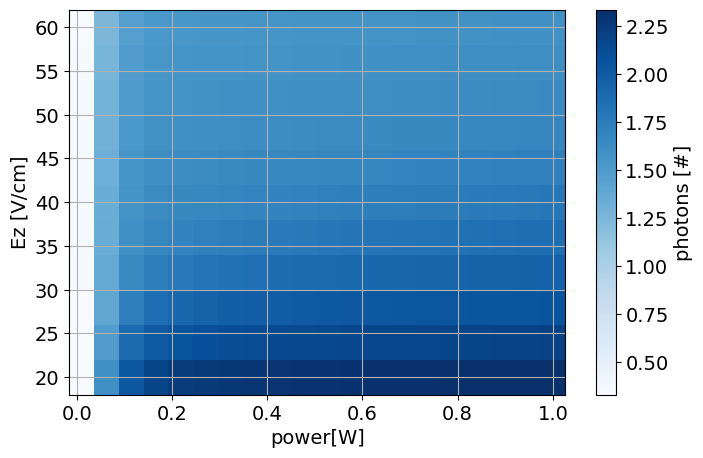

In [11]:
fig, ax = plt.subplots(figsize = (8,5)) 
cax = ax.pcolormesh(pow_reg, Ez_reg, res_fin,cmap='Blues')
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel("photons [#]")
ax.set_xlabel("power[W]")
ax.set_ylabel("Ez [V/cm]")
#ax.set_title(f"Ω = {powers[idΩ]} W")
ax.grid(True)

In [12]:
import pickle
# Open a file and use dump()
with open('unforbidden_smallE_photons.pickle', 'wb') as f:
    pickle.dump(res_fin,f)

Text(0.5, 1.0, '# of photons from "forbidden" transition')

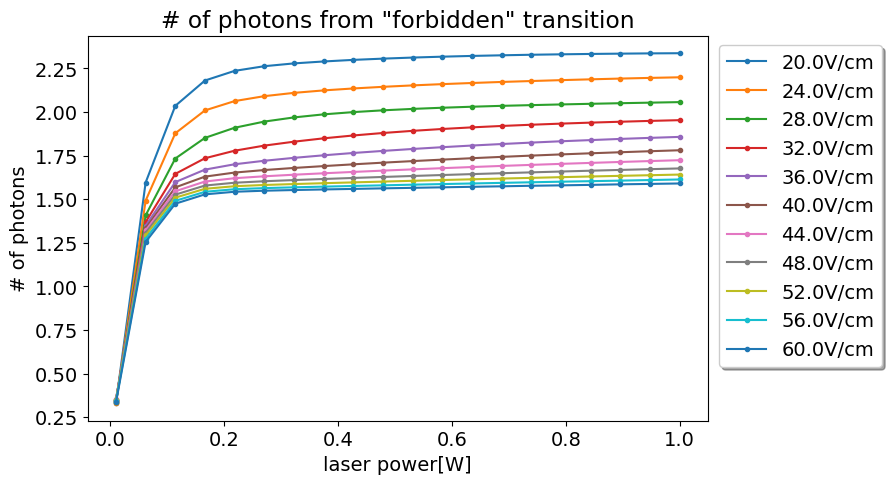

In [13]:
fig2, ax2 = plt.subplots(figsize = (8,5)) 
for i in range(len(Ez_reg)):
    ax2.plot(pow_reg, res_fin[i], '.-',label = f"{Ez_reg[i]}V/cm")
ax2.legend(loc='upper center', bbox_to_anchor=(1.15, 1.),
          ncol=1, fancybox=True, shadow=True)
ax2.set_xlabel('laser power[W]')
ax2.set_ylabel('# of photons')
ax2.set_title('# of photons from "forbidden" transition')

In [18]:
for_lowE_data_file = open('forbidden_smallE_photons.pickle', 'rb')
for_data_file = open('forbidden_photons.pickle', 'rb')
for_lowE_data = pickle.load(for_lowE_data_file)
for_data = pickle.load(for_data_file)


[[1.81036582e-01 1.28128889e+00 2.05734773e+00 2.52987460e+00
  2.80960876e+00 2.97575227e+00 3.07563933e+00 3.13667480e+00
  3.17418661e+00 3.19868772e+00 3.21405610e+00 3.22462745e+00
  3.23242710e+00 3.23741859e+00 3.24093977e+00 3.24384429e+00
  3.24562944e+00 3.24760936e+00 3.24832880e+00 3.24968061e+00]
 [9.51024162e-02 7.97238881e-01 1.42578005e+00 1.81971066e+00
  2.02048652e+00 2.12003228e+00 2.18170714e+00 2.23407703e+00
  2.28520938e+00 2.33546520e+00 2.38383684e+00 2.42919243e+00
  2.47053696e+00 2.50777950e+00 2.54068540e+00 2.56941707e+00
  2.59439631e+00 2.61586916e+00 2.63404818e+00 2.64949543e+00]
 [2.02997022e-03 1.48676628e-02 2.78759373e-02 4.08387200e-02
  5.37314256e-02 6.65195169e-02 7.91636596e-02 9.16460880e-02
  1.03978202e-01 1.16242247e-01 1.28552609e-01 1.41044261e-01
  1.53850236e-01 1.67062521e-01 1.80719719e-01 1.94764775e-01
  2.09111097e-01 2.23568397e-01 2.38021770e-01 2.52280718e-01]
 [5.57454679e-04 4.18084995e-03 7.94787935e-03 1.17351477e-02
  1.5